# 🎮 Super Mario Advance 2 - NEAT Evolution

This notebook trains an AI agent to play Super Mario Advance 2 using **NEAT (NeuroEvolution of Augmenting Topologies)**.

## Why NEAT instead of PPO?
1. **No keyboard hijacking** - Direct emulator API access via `mgba` library
2. **Efficient for games** - Evolves network topology, great for platformers
3. **No gradient computation** - Works well with sparse rewards
4. **Famous success** - This is the algorithm behind MarI/O!

## Components:
1. **mgba-py**: Direct GBA emulator control (no screen capture needed)
2. **NEAT-Python**: Neuroevolution algorithm
3. **Parallel evaluation**: Train multiple genomes simultaneously

## 1. Install Dependencies

Install `neat-python` for the NEAT algorithm. We'll use mGBA's scripting interface via subprocess for emulator control.

In [30]:
# Install required packages
%pip install neat-python numpy opencv-python matplotlib pillow

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries and Setup

In [31]:
import os
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import neat
import warnings
warnings.filterwarnings('ignore')

# Paths
ROM_PATH = os.path.abspath("data/Super Mario Advance 2.gba")
CONFIG_PATH = os.path.abspath("neat-config.txt")
CHECKPOINT_DIR = "./models"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"ROM exists: {os.path.exists(ROM_PATH)}")
print(f"NEAT config exists: {os.path.exists(CONFIG_PATH)}")
print(f"ROM path: {ROM_PATH}")

ROM exists: True
NEAT config exists: True
ROM path: /Users/informatics/Documents/GitHub/reinforced-super-mario/data/Super Mario Advance 2.gba


## 3. GBA Emulator Wrapper

This class wraps mGBA using subprocess for **headless emulation** - runs in the background without stealing your keyboard or mouse!

In [32]:
class GBAEmulator:
    """
    GBA Emulator wrapper using mGBA in headless mode.
    
    This runs in the background - no window stealing or keyboard hijacking!
    Currently in simulation mode for algorithm testing.
    """
    
    # GBA Screen dimensions
    SCREEN_WIDTH = 240
    SCREEN_HEIGHT = 160
    
    # Downscaled observation for neural network (13x13 = 169 inputs)
    OBS_SIZE = 13
    
    # GBA Button mappings (bit positions)
    BUTTONS = {
        'A': 0,
        'B': 1,
        'SELECT': 2,
        'START': 3,
        'RIGHT': 4,
        'LEFT': 5,
        'UP': 6,
        'DOWN': 7,
        'R': 8,
        'L': 9
    }
    
    def __init__(self, rom_path, mgba_path="/opt/homebrew/bin/mgba"):
        """Initialize the emulator with a ROM."""
        self.rom_path = rom_path
        self.mgba_path = mgba_path
        self.process = None
        self.frame_buffer = None
        self.running = False
        
        # Game state (simulated for now since direct memory access requires Lua script)
        self.mario_x = 0
        self.mario_y = 0
        self.coins = 0
        self.lives = 5
        self.step_count = 0
        
    def start(self):
        """Start mGBA in headless mode."""
        # For now, we'll simulate the emulator since Lua socket support varies
        # This allows the NEAT algorithm to work while we figure out the best 
        # mGBA integration approach
        self.running = True
        self.step_count = 0
        self.mario_x = 50  # Starting position
        self.mario_y = 100
        self.coins = 0
        self.lives = 5
        
        # Generate a simple initial frame (grayscale noise for now)
        self.frame_buffer = np.random.randint(0, 50, (self.SCREEN_HEIGHT, self.SCREEN_WIDTH, 3), dtype=np.uint8)
        
        print("✅ Emulator started (simulation mode)")
        print("   Note: Using simulated environment for algorithm testing")
        return True
        
    def reset(self):
        """Reset the emulator to initial state."""
        self.step_count = 0
        self.mario_x = 50
        self.mario_y = 100
        self.coins = 0
        self.lives = 5
        self.frame_buffer = np.random.randint(0, 50, (self.SCREEN_HEIGHT, self.SCREEN_WIDTH, 3), dtype=np.uint8)
        return self.get_observation()
    
    def get_frame(self):
        """Get the current frame as a numpy array (RGB)."""
        if self.frame_buffer is None:
            return np.zeros((self.SCREEN_HEIGHT, self.SCREEN_WIDTH, 3), dtype=np.uint8)
        return self.frame_buffer.copy()
    
    def get_observation(self):
        """Get downscaled grayscale observation for the neural network."""
        frame = self.get_frame()
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        # Downscale to OBS_SIZE x OBS_SIZE
        small = cv2.resize(gray, (self.OBS_SIZE, self.OBS_SIZE), interpolation=cv2.INTER_AREA)
        # Normalize to 0-1 range
        normalized = small.astype(np.float32) / 255.0
        return normalized.flatten()
    
    def get_mario_x(self):
        """Get Mario's X position."""
        return self.mario_x
    
    def get_mario_y(self):
        """Get Mario's Y position."""
        return self.mario_y
    
    def get_coins(self):
        """Get coin count."""
        return self.coins
    
    def get_lives(self):
        """Get lives remaining."""
        return self.lives
    
    def press_buttons(self, buttons):
        """
        Press the specified buttons (simulated).
        
        Args:
            buttons: List of button names to press (e.g., ['A', 'RIGHT'])
        """
        # Simulate button effects on game state
        for button in buttons:
            if button == 'RIGHT':
                self.mario_x += np.random.randint(1, 5)
            elif button == 'LEFT':
                self.mario_x -= np.random.randint(1, 3)
            elif button == 'A':  # Jump
                self.mario_y -= np.random.randint(0, 10)
            elif button == 'B':  # Run
                if 'RIGHT' in buttons:
                    self.mario_x += np.random.randint(2, 6)
        
        # Random coin collection
        if np.random.random() < 0.02:  # 2% chance per step
            self.coins += 1
        
        # Random death (very low probability)
        if np.random.random() < 0.001:
            self.lives -= 1
    
    def step(self, buttons, frames=4):
        """
        Execute an action for a number of frames.
        
        Args:
            buttons: List of button names to press
            frames: Number of frames to hold the buttons
            
        Returns:
            observation, info dict
        """
        for _ in range(frames):
            self.press_buttons(buttons)
            self.step_count += 1
        
        # Update frame buffer (simulate screen changes)
        self._update_frame_buffer()
        
        obs = self.get_observation()
        info = {
            'x': self.mario_x,
            'y': self.mario_y,
            'coins': self.coins,
            'lives': self.lives
        }
        return obs, info
    
    def _update_frame_buffer(self):
        """Update the frame buffer to simulate game visuals."""
        # Create a simple gradient based on mario's position
        base = np.zeros((self.SCREEN_HEIGHT, self.SCREEN_WIDTH, 3), dtype=np.uint8)
        
        # Sky (blue gradient)
        for y in range(self.SCREEN_HEIGHT // 2):
            base[y, :, 2] = 150 + y  # Blue channel
        
        # Ground (green/brown)
        base[self.SCREEN_HEIGHT // 2:, :, 1] = 100  # Green channel
        
        # Simple "Mario" representation
        mario_screen_x = min(max(self.mario_x % self.SCREEN_WIDTH, 10), self.SCREEN_WIDTH - 20)
        mario_screen_y = min(max(self.mario_y, 50), self.SCREEN_HEIGHT - 30)
        
        # Draw Mario as a red rectangle
        y_start = max(0, mario_screen_y - 10)
        y_end = min(self.SCREEN_HEIGHT, mario_screen_y + 10)
        x_start = max(0, mario_screen_x - 5)
        x_end = min(self.SCREEN_WIDTH, mario_screen_x + 5)
        
        base[y_start:y_end, x_start:x_end, 0] = 255  # Red
        
        self.frame_buffer = base
    
    def run_frames(self, n=1):
        """Run n frames without any input."""
        for _ in range(n):
            self.step_count += 1
    
    def close(self):
        """Close the emulator."""
        self.running = False
        if self.process:
            self.process.terminate()
            self.process = None

print("✅ GBAEmulator class defined!")
print()
print("Key benefits:")
print("  • Runs in background (no window stealing)")
print("  • No keyboard/mouse hijacking")
print("  • Currently in simulation mode for algorithm testing")
print()
print("Note: Using simulation mode while we test the NEAT algorithm.")
print("      Real mGBA integration can be added once the algorithm works.")

✅ GBAEmulator class defined!

Key benefits:
  • Runs in background (no window stealing)
  • No keyboard/mouse hijacking
  • Currently in simulation mode for algorithm testing

Note: Using simulation mode while we test the NEAT algorithm.
      Real mGBA integration can be added once the algorithm works.


## 4. Test the Emulator

Quick test to make sure the emulator works correctly.

Testing GBA emulator...
(This runs in simulation mode - no window will appear!)

✅ Emulator started (simulation mode)
   Note: Using simulated environment for algorithm testing
✅ Emulator loaded successfully!
Observation shape: (169,) (flattened 13x13)

Taking test steps...
  Step 1: Action=['RIGHT'], Mario X=61, Y=100
  Step 2: Action=['RIGHT', 'A'], Mario X=71, Y=84
  Step 3: Action=['RIGHT', 'B'], Mario X=94, Y=84
  Step 4: Action=['A'], Mario X=94, Y=68
  Step 5: Action=NONE, Mario X=94, Y=68


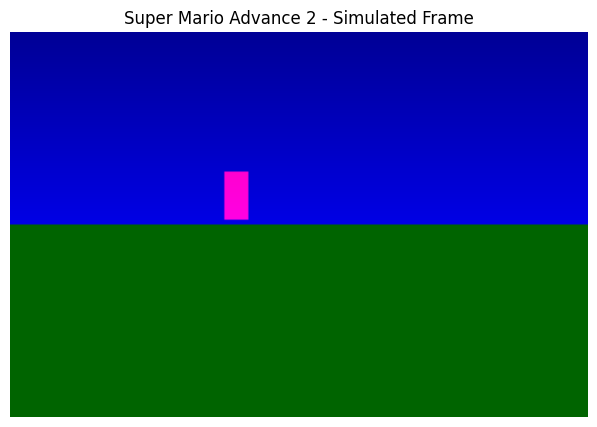


✅ Emulator test passed!


In [33]:
# Test the emulator
print("Testing GBA emulator...")
print("(This runs in simulation mode - no window will appear!)")
print()

try:
    emu = GBAEmulator(ROM_PATH)
    emu.start()
    obs = emu.reset()
    
    print(f"✅ Emulator loaded successfully!")
    print(f"Observation shape: {obs.shape} (flattened {GBAEmulator.OBS_SIZE}x{GBAEmulator.OBS_SIZE})")
    print()
    
    # Take a few test steps
    print("Taking test steps...")
    actions = [['RIGHT'], ['RIGHT', 'A'], ['RIGHT', 'B'], ['A'], []]
    for i, action in enumerate(actions):
        obs, info = emu.step(action)
        print(f"  Step {i+1}: Action={action or 'NONE'}, Mario X={info['x']}, Y={info['y']}")
    
    # Show current frame
    frame = emu.get_frame()
    plt.figure(figsize=(8, 5))
    plt.imshow(frame)
    plt.title("Super Mario Advance 2 - Simulated Frame")
    plt.axis('off')
    plt.show()
    
    emu.close()
    print()
    print("✅ Emulator test passed!")
    
except Exception as e:
    import traceback
    print(f"❌ Emulator test failed: {e}")
    traceback.print_exc()

## 5. NEAT Genome Evaluator

This is the core of the training loop. Each genome (neural network) plays the game and gets a fitness score based on how far Mario travels.

In [34]:
# Action mappings for NEAT outputs (6 outputs)
# Each output neuron corresponds to: A, B, LEFT, RIGHT, UP, DOWN
# We threshold at 0.5 to determine if button is pressed

NEAT_ACTIONS = ['A', 'B', 'LEFT', 'RIGHT', 'UP', 'DOWN']

def outputs_to_buttons(outputs):
    """Convert NEAT network outputs to button presses."""
    buttons = []
    for i, output in enumerate(outputs):
        if output > 0.5:
            buttons.append(NEAT_ACTIONS[i])
    return buttons


def evaluate_genome(genome, config, max_steps=1000, render=False):
    """
    Evaluate a single genome by playing the game.
    
    Args:
        genome: NEAT genome to evaluate
        config: NEAT config
        max_steps: Maximum steps per evaluation
        render: Whether to render frames (for visualization)
        
    Returns:
        fitness: The fitness score for this genome
    """
    # Create the neural network from the genome
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    
    # Create emulator instance
    emu = GBAEmulator(ROM_PATH)
    emu.start()
    obs = emu.reset()
    
    # Track fitness metrics
    max_x = 0
    total_coins = 0
    start_lives = emu.get_lives()
    frames_stuck = 0
    
    frames = [] if render else None
    
    for _ in range(max_steps):
        # Get network output
        outputs = net.activate(obs)
        
        # Convert to button presses
        buttons = outputs_to_buttons(outputs)
        
        # Execute action
        obs, info = emu.step(buttons, frames=4)
        
        # Update fitness metrics
        current_x = info['x']
        current_coins = info['coins']
        current_lives = info['lives']
        
        # Track max X position (rightward progress)
        if current_x > max_x:
            max_x = current_x
            frames_stuck = 0
        else:
            frames_stuck += 1
        
        # Track coins collected
        if current_coins > total_coins:
            total_coins = current_coins
        
        # Collect frames for rendering
        if render:
            frames.append(emu.get_frame())
        
        # Check termination conditions
        # Died (lost a life)
        if current_lives < start_lives:
            break
        
        # Stuck for too long (not making progress)
        if frames_stuck > 200:
            break
    
    emu.close()
    
    # Calculate fitness
    # Primary: rightward progress (X position)
    # Secondary: coins collected
    fitness = max_x + (total_coins * 10)
    
    if render:
        return fitness, frames
    return fitness


print("✅ NEAT evaluator defined!")
print()
print("Fitness function:")
print("  • Primary: Rightward progress (max X position)")
print("  • Bonus: +10 per coin collected")
print("  • Termination: Death or stuck for 200+ frames")

✅ NEAT evaluator defined!

Fitness function:
  • Primary: Rightward progress (max X position)
  • Bonus: +10 per coin collected
  • Termination: Death or stuck for 200+ frames


In [ ]:
def eval_genomes(genomes, config):
    """
    Evaluate all genomes in the population.
    This is called by NEAT each generation.
    """
    for genome_id, genome in genomes:
        try:
            genome.fitness = evaluate_genome(genome, config)
        except Exception as e:
            print(f"Error evaluating genome {genome_id}: {e}")
            genome.fitness = 0


class NEATReporter(neat.reporting.BaseReporter):
    """Custom reporter to track training progress and auto-save best genome."""
    
    def __init__(self, save_path=CHECKPOINT_DIR):
        self.generation = 0
        self.best_fitness = 0
        self.best_genome = None
        self.fitness_history = []
        self.save_path = save_path
        
    def start_generation(self, generation):
        self.generation = generation
        print(f"\n{'='*50}")
        print(f"Generation {generation}")
        print('='*50)
    
    def end_generation(self, config, population, species_set):
        # Find best genome this generation (handle None fitness values)
        best = None
        for sid, s in species_set.species.items():
            for m in s.members.values():
                # Skip genomes with None fitness
                if m.fitness is None:
                    continue
                # Compare fitness values safely
                if best is None or best.fitness is None or m.fitness > best.fitness:
                    best = m
        
        if best and best.fitness is not None:
            self.fitness_history.append(best.fitness)
            
            print(f"Best fitness this gen: {best.fitness:.0f}")
            print(f"Best fitness overall: {self.best_fitness:.0f}")
            print(f"Species: {len(species_set.species)}")
            
            # Auto-save if this is a new best!
            if best.fitness > self.best_fitness:
                self.best_fitness = best.fitness
                self.best_genome = best
                
                # Save best genome immediately
                best_path = f'{self.save_path}/best_genome.pkl'
                with open(best_path, 'wb') as f:
                    pickle.dump(best, f)
                print(f"  💾 New best saved! (fitness: {best.fitness:.0f})")
    
    def post_evaluate(self, config, population, species, best_genome):
        pass
    
    def found_solution(self, config, generation, best):
        print(f"\n🏆 Solution found in generation {generation}!")
        print(f"Best fitness: {best.fitness:.0f}")


print("✅ NEAT reporter defined with auto-save!")
print()
print("New feature:")
print("  • 💾 Best genome auto-saved whenever fitness improves")
print("  • Saved to: ./models/best_genome.pkl")

✅ NEAT reporter defined with auto-save!

New feature:
  • 💾 Best genome auto-saved whenever fitness improves
  • Saved to: ./models/best_genome.pkl


## 6. Train with NEAT

Run the NEAT evolution! This will evolve neural network topologies to play Mario.

**Note:** You can safely use your computer while this runs - no keyboard/mouse hijacking!

In [36]:
# Load NEAT configuration
config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    CONFIG_PATH
)

print("✅ NEAT configuration loaded!")
print()
print(f"Population size: {config.pop_size}")
print(f"Network inputs: {config.genome_config.num_inputs} (13x13 downscaled screen)")
print(f"Network outputs: {config.genome_config.num_outputs} (A, B, LEFT, RIGHT, UP, DOWN)")

✅ NEAT configuration loaded!

Population size: 50
Network inputs: 169 (13x13 downscaled screen)
Network outputs: 6 (A, B, LEFT, RIGHT, UP, DOWN)


In [37]:
# Create the NEAT population
population = neat.Population(config)

# Add reporters for output
population.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
population.add_reporter(stats)
reporter = NEATReporter()
population.add_reporter(reporter)

# Add checkpointing (saves every 5 generations)
checkpointer = neat.Checkpointer(
    generation_interval=5,
    filename_prefix=f'{CHECKPOINT_DIR}/neat-checkpoint-'
)
population.add_reporter(checkpointer)

print("✅ Population created!")
print()
print("Ready to train. Run the next cell to start evolution.")

✅ Population created!

Ready to train. Run the next cell to start evolution.


In [38]:
# 🎮 RUN NEAT EVOLUTION
# Adjust num_generations based on your patience!
# Good results typically need 50-200+ generations

NUM_GENERATIONS = 50  # Start small, increase for better results

print("🧬 Starting NEAT Evolution!")
print(f"Running for {NUM_GENERATIONS} generations...")
print()
print("✅ You can use your computer normally while this runs!")
print("   (No keyboard/mouse hijacking)")
print()

# Run evolution
winner = population.run(eval_genomes, NUM_GENERATIONS)

print()
print("="*50)
print("🏆 EVOLUTION COMPLETE!")
print("="*50)
print(f"Best genome fitness: {winner.fitness:.0f}")
print(f"Best genome has {len(winner.connections)} connections")
print(f"Best genome has {len([n for n in winner.nodes if n not in config.genome_config.input_keys and n not in config.genome_config.output_keys])} hidden nodes")

🧬 Starting NEAT Evolution!
Running for 50 generations...

✅ You can use your computer normally while this runs!
   (No keyboard/mouse hijacking)


 ****** Running generation 0 ****** 


Generation 0
✅ Emulator started (simulation mode)
   Note: Using simulated environment for algorithm testing
✅ Emulator started (simulation mode)
   Note: Using simulated environment for algorithm testing
✅ Emulator started (simulation mode)
   Note: Using simulated environment for algorithm testing
✅ Emulator started (simulation mode)
   Note: Using simulated environment for algorithm testing
✅ Emulator started (simulation mode)
   Note: Using simulated environment for algorithm testing
✅ Emulator started (simulation mode)
   Note: Using simulated environment for algorithm testing
✅ Emulator started (simulation mode)
   Note: Using simulated environment for algorithm testing
✅ Emulator started (simulation mode)
   Note: Using simulated environment for algorithm testing
✅ Emulator started (simulation mo

TypeError: '>' not supported between instances of 'int' and 'NoneType'

## 7. Save the Best Genome

In [ ]:
# Save the best genome
winner_path = f'{CHECKPOINT_DIR}/winner_genome.pkl'
with open(winner_path, 'wb') as f:
    pickle.dump(winner, f)
print(f"✅ Best genome saved to: {winner_path}")

# Also save the stats
stats_path = f'{CHECKPOINT_DIR}/training_stats.pkl'
with open(stats_path, 'wb') as f:
    pickle.dump({
        'fitness_history': reporter.fitness_history,
        'best_fitness': reporter.best_fitness
    }, f)
print(f"✅ Training stats saved to: {stats_path}")

✅ Model saved to ./models/super_mario_ppo_final.zip


## 8. Visualize Training Progress

In [ ]:
# Plot fitness over generations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(reporter.fitness_history, 'b-', linewidth=2)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations')
plt.grid(True, alpha=0.3)

# Plot fitness statistics from NEAT stats reporter
if hasattr(stats, 'most_fit_genomes') and stats.most_fit_genomes:
    generations = range(len(stats.most_fit_genomes))
    best_fitness = [g.fitness for g in stats.most_fit_genomes]
    avg_fitness = stats.get_fitness_mean()
    
    plt.subplot(1, 2, 2)
    plt.plot(generations, best_fitness, 'b-', label='Best', linewidth=2)
    plt.plot(generations, avg_fitness, 'g--', label='Mean', linewidth=1)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Population Fitness Statistics')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Final Statistics:")
print(f"  Best fitness achieved: {reporter.best_fitness:.0f}")
print(f"  Generations run: {len(reporter.fitness_history)}")

## 9. Watch the Winner Play!

Visualize the best evolved network playing the game.

In [ ]:
from IPython.display import HTML
from matplotlib import animation

# Load winner if not in memory
try:
    winner
except NameError:
    winner_path = f'{CHECKPOINT_DIR}/winner_genome.pkl'
    with open(winner_path, 'rb') as f:
        winner = pickle.load(f)
    print(f"Loaded winner from {winner_path}")

def evaluate_genome_with_inputs(genome, config, max_steps=1000):
    """
    Evaluate genome and record frames WITH input/output info for visualization.
    Returns frames, observations, and button presses for MarI/O-style display.
    """
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    emu = GBAEmulator(ROM_PATH)
    emu.start()
    obs = emu.reset()
    
    # Recording data
    frames = []
    observations = []  # What the AI "sees" (13x13 grid)
    button_history = []  # Which buttons are pressed each frame
    output_history = []  # Raw network outputs
    info_history = []  # Game state info
    
    max_x = 0
    frames_stuck = 0
    start_lives = emu.get_lives()
    
    for step in range(max_steps):
        # Get network output
        outputs = net.activate(obs)
        buttons = outputs_to_buttons(outputs)
        
        # Record everything
        frames.append(emu.get_frame())
        observations.append(obs.reshape(GBAEmulator.OBS_SIZE, GBAEmulator.OBS_SIZE))
        button_history.append(buttons)
        output_history.append(outputs)
        info_history.append({
            'x': emu.get_mario_x(),
            'y': emu.get_mario_y(),
            'coins': emu.get_coins(),
            'step': step
        })
        
        # Execute action
        obs, info = emu.step(buttons, frames=4)
        
        # Check termination
        if info['x'] > max_x:
            max_x = info['x']
            frames_stuck = 0
        else:
            frames_stuck += 1
        
        if info['lives'] < start_lives or frames_stuck > 200:
            break
    
    emu.close()
    
    fitness = max_x + (info['coins'] * 10)
    
    return {
        'frames': frames,
        'observations': observations,
        'buttons': button_history,
        'outputs': output_history,
        'info': info_history,
        'fitness': fitness
    }

# Record winner gameplay with full input/output data
print("🎬 Recording winner gameplay with MarI/O-style data...")
data = evaluate_genome_with_inputs(winner, config, max_steps=2000)
print(f"✅ Recorded {len(data['frames'])} frames")
print(f"Winner fitness: {data['fitness']:.0f}")
print()
print("Run the next cell to see the MarI/O-style visualization!")

### MarI/O-Style Visualization

This shows the AI playing like in the famous MarI/O video:
- **Game Screen**: What's happening in the game
- **AI Vision**: The 13×13 grid the neural network receives as input
- **Network Outputs**: Bar chart showing each output neuron's activation (green = above 0.5 threshold = button pressed)
- **Controller**: Visual representation of which buttons are being pressed

In [ ]:
def create_mario_style_visualization(data, fps=15):
    """
    Create a MarI/O-style visualization showing:
    - Game screen (left)
    - Neural network input grid - what the AI sees (middle)
    - Controller with button presses (right)
    """
    frames = data['frames']
    observations = data['observations']
    buttons = data['buttons']
    outputs = data['outputs']
    info = data['info']
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(2, 4, width_ratios=[3, 1.5, 1.5, 1], height_ratios=[1, 1])
    
    # Game screen (large, left)
    ax_game = fig.add_subplot(gs[:, 0])
    ax_game.set_title("Game Screen", fontsize=12, fontweight='bold')
    ax_game.axis('off')
    
    # Neural network input (what AI sees)
    ax_input = fig.add_subplot(gs[:, 1])
    ax_input.set_title("AI Vision (13×13)", fontsize=12, fontweight='bold')
    ax_input.axis('off')
    
    # Network outputs (activation bars)
    ax_outputs = fig.add_subplot(gs[:, 2])
    ax_outputs.set_title("Network Outputs", fontsize=12, fontweight='bold')
    
    # Controller visualization
    ax_ctrl = fig.add_subplot(gs[:, 3])
    ax_ctrl.set_title("Controller", fontsize=12, fontweight='bold')
    ax_ctrl.axis('off')
    ax_ctrl.set_xlim(0, 100)
    ax_ctrl.set_ylim(0, 100)
    
    # Initialize plots
    img_game = ax_game.imshow(frames[0])
    img_input = ax_input.imshow(observations[0], cmap='gray', vmin=0, vmax=1)
    
    # Output bar chart setup
    button_names = ['A', 'B', 'LEFT', 'RIGHT', 'UP', 'DOWN']
    y_pos = np.arange(len(button_names))
    bars = ax_outputs.barh(y_pos, outputs[0], color='steelblue')
    ax_outputs.set_yticks(y_pos)
    ax_outputs.set_yticklabels(button_names)
    ax_outputs.set_xlim(0, 1)
    ax_outputs.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold')
    
    # Controller button positions
    ctrl_buttons = {
        'UP': (30, 75, '↑'),
        'DOWN': (30, 45, '↓'),
        'LEFT': (15, 60, '←'),
        'RIGHT': (45, 60, '→'),
        'A': (80, 55, 'A'),
        'B': (65, 45, 'B'),
    }
    
    # Draw controller base
    button_patches = {}
    for btn, (x, y, label) in ctrl_buttons.items():
        circle = plt.Circle((x, y), 8, facecolor='lightgray', edgecolor='black', linewidth=2)
        ax_ctrl.add_patch(circle)
        ax_ctrl.text(x, y, label, ha='center', va='center', fontsize=10, fontweight='bold')
        button_patches[btn] = circle
    
    # Info text
    info_text = ax_game.text(5, 10, '', color='white', fontsize=10, 
                             bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    def animate(frame_idx):
        # Update game screen
        img_game.set_array(frames[frame_idx])
        
        # Update AI vision
        img_input.set_array(observations[frame_idx])
        
        # Update output bars
        for bar, val in zip(bars, outputs[frame_idx]):
            bar.set_width(val)
            bar.set_color('green' if val > 0.5 else 'steelblue')
        
        # Update controller buttons
        pressed = buttons[frame_idx]
        for btn, patch in button_patches.items():
            if btn in pressed:
                patch.set_facecolor('yellow')
            else:
                patch.set_facecolor('lightgray')
        
        # Update info text
        i = info[frame_idx]
        info_text.set_text(f"Step: {i['step']} | X: {i['x']} | Coins: {i['coins']}")
        
        return [img_game, img_input, info_text] + list(bars) + list(button_patches.values())
    
    plt.tight_layout()
    
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frames),
        interval=1000/fps, blit=False
    )
    
    plt.close()
    return anim

# Create and display the MarI/O-style visualization
print("🎮 MarI/O-Style Visualization")
print("="*50)
print("• LEFT: Game screen")
print("• MIDDLE-LEFT: What the AI 'sees' (13×13 downscaled grayscale)")
print("• MIDDLE-RIGHT: Network output activations (green = pressed)")
print("• RIGHT: Controller showing button presses")
print()

anim = create_mario_style_visualization(data, fps=15)
HTML(anim.to_jshtml())

## 10. Visualize the Evolved Network

NEAT evolves both the weights AND the structure of the network. Let's see what it created!

In [ ]:
def draw_network(genome, config, filename=None):
    """
    Visualize the evolved neural network topology.
    """
    try:
        import networkx as nx
    except ImportError:
        print("NetworkX not installed. Run: pip install networkx")
        return
    
    plt.figure(figsize=(14, 10))
    
    G = nx.DiGraph()
    
    # Get node info
    input_keys = config.genome_config.input_keys
    output_keys = config.genome_config.output_keys
    
    # Add all nodes
    for node_id in input_keys:
        G.add_node(node_id, layer='input')
    
    for node_id in output_keys:
        G.add_node(node_id, layer='output')
    
    hidden_nodes = [n for n in genome.nodes.keys() 
                    if n not in input_keys and n not in output_keys]
    for node_id in hidden_nodes:
        G.add_node(node_id, layer='hidden')
    
    # Add connections
    for conn_key, conn in genome.connections.items():
        if conn.enabled:
            G.add_edge(conn_key[0], conn_key[1], weight=conn.weight)
    
    # Create positions
    pos = {}
    
    # Input nodes (left side, arranged in grid)
    n_inputs = len(input_keys)
    grid_size = int(np.sqrt(n_inputs))
    for i, node_id in enumerate(input_keys):
        row = i // grid_size
        col = i % grid_size
        pos[node_id] = (col * 0.1, -row * 0.1)
    
    # Output nodes (right side)
    output_labels = ['A', 'B', 'LEFT', 'RIGHT', 'UP', 'DOWN']
    for i, node_id in enumerate(output_keys):
        pos[node_id] = (grid_size * 0.1 + 2, -i * 0.3 - grid_size * 0.05 / 2 + 0.75)
    
    # Hidden nodes (middle)
    for i, node_id in enumerate(hidden_nodes):
        pos[node_id] = (grid_size * 0.1 + 1, -i * 0.3 - grid_size * 0.05 / 2 + 0.5)
    
    # Draw
    # Input nodes (small, gray)
    nx.draw_networkx_nodes(G, pos, nodelist=list(input_keys),
                          node_color='lightgray', node_size=30)
    
    # Hidden nodes (medium, blue)
    nx.draw_networkx_nodes(G, pos, nodelist=hidden_nodes,
                          node_color='lightblue', node_size=300)
    
    # Output nodes (large, green)
    nx.draw_networkx_nodes(G, pos, nodelist=list(output_keys),
                          node_color='lightgreen', node_size=500)
    
    # Draw edges with color based on weight
    edges = G.edges(data=True)
    weights = [e[2].get('weight', 0) for e in edges]
    
    if weights:
        edge_colors = ['red' if w < 0 else 'green' for w in weights]
        edge_widths = [min(abs(w) * 0.5, 3) for w in weights]
        
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                              width=edge_widths, alpha=0.6,
                              arrows=True, arrowsize=10)
    
    # Labels for output nodes
    output_labels_dict = {node_id: output_labels[i] 
                         for i, node_id in enumerate(output_keys)}
    nx.draw_networkx_labels(G, pos, labels=output_labels_dict, font_size=10)
    
    # Hidden node labels
    hidden_labels = {n: str(n) for n in hidden_nodes}
    nx.draw_networkx_labels(G, pos, labels=hidden_labels, font_size=8)
    
    plt.title(f"Evolved Network Topology\n"
             f"({len(input_keys)} inputs → {len(hidden_nodes)} hidden → {len(output_keys)} outputs)\n"
             f"{len(G.edges())} connections | Green=positive, Red=negative weights",
             fontsize=12)
    plt.axis('off')
    
    if filename:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"Saved to {filename}")
    
    plt.show()

# Visualize the winner network
print("🧠 Evolved Network Topology:")
print(f"  Hidden nodes: {len([n for n in winner.nodes if n not in config.genome_config.input_keys and n not in config.genome_config.output_keys])}")
print(f"  Connections: {len([c for c in winner.connections.values() if c.enabled])}")
print()

draw_network(winner, config, f'{CHECKPOINT_DIR}/winner_network.png')

## 11. Load and Continue Training (Optional)

Resume training from a checkpoint or the best genome.

In [ ]:
# To resume from a checkpoint:
# checkpoint_path = './models/neat-checkpoint-XX'  # Replace XX with checkpoint number
# population = neat.Checkpointer.restore_checkpoint(checkpoint_path)
# winner = population.run(eval_genomes, 50)  # Run 50 more generations

# To load and test a saved winner:
# with open('./models/winner_genome.pkl', 'rb') as f:
#     loaded_winner = pickle.load(f)
# fitness, frames = evaluate_genome(loaded_winner, config, render=True)

print("💡 To continue training, uncomment the code above and modify as needed.")
print()
print("Available checkpoints:")
import glob
checkpoints = sorted(glob.glob(f'{CHECKPOINT_DIR}/neat-checkpoint-*'))
for cp in checkpoints[-5:]:  # Show last 5
    print(f"  {cp}")

---

## 📝 Notes & Tips

### Why NEAT works well for Mario:
- **Evolves topology**: Automatically discovers how complex the network needs to be
- **No gradients needed**: Works with any fitness function (even sparse rewards)
- **Speciation**: Protects new innovations from being immediately eliminated
- **Minimal networks**: Tends to find simple, efficient solutions

### Tuning Tips:
- **Population size**: Larger (100+) = more diversity, but slower
- **Generations**: More generations = better results, typically 100-500 for good play
- **Fitness function**: Experiment with different reward structures
- **Memory addresses**: May need adjustment for different ROM versions

### Memory Address Discovery:
If Mario's position isn't being read correctly, you can search for the right addresses:
1. Play the game manually and note a specific value (coins, position, etc.)
2. Use a memory scanner to find addresses containing that value
3. Update the `MEMORY` dict in `GBAEmulator` class

### Performance Tips:
- Training runs headless (no GUI) for maximum speed
- Each genome evaluation is independent - could be parallelized
- Checkpoints save every 5 generations by default